In [1]:
from rolling import *
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import healpy as hp
from lsst.sims.featureScheduler import utils
import sys

In [2]:
nside = 32
per_night = True  # Dither DDF per night
nexp = 1  # All observations
mixed_pairs = True  # For the blob scheduler
camera_ddf_rot_limit = 75.
max_dither = 0.7

scale_down_factor = 0.2
mod_year = 6
illum_limit = 40

fileroot = 'rolling_'+'mod%i_sdf_%.2f_' % (mod_year, scale_down_factor)
file_end = 'v1.5_'

# Set up the DDF surveys to dither
dither_detailer = detailers.Dither_detailer(per_night=per_night, max_dither=max_dither)
details = [detailers.Camera_rot_detailer(min_rot=-camera_ddf_rot_limit, max_rot=camera_ddf_rot_limit), dither_detailer]
ddfs = generate_dd_surveys(nside=nside, nexp=nexp, detailers=details)

observatory = Model_observatory(nside=nside)
conditions = observatory.return_conditions()
# Mark position of the sun at the start of the survey. Usefull for rolling cadence.
sun_ra_0 = conditions.sunRA  # radians
offset = create_season_offset(nside, sun_ra_0)
max_season = 6

sg = standard_goals()
roll_maps = slice_wfd_area(mod_year, sg, scale_down_factor=scale_down_factor)
footprints = roll_maps + [sg]

all_footprints_sum = 0
all_rolling_sum = 0

wfd_indx = np.where(sg['r'] == 1)
for fp in sg:
    all_footprints_sum += np.sum(sg[fp])
    all_rolling_sum += np.sum(sg[fp][wfd_indx])

greedy = gen_greedy_surveys(nside, nexp=nexp, footprints=footprints, season_modulo=mod_year,
                            all_footprints_sum=all_footprints_sum, all_rolling_sum=all_rolling_sum,
                            day_offset=offset, max_season=max_season)
blobs = generate_blobs(nside, nexp=nexp, footprints=footprints, season_modulo=mod_year,
                       all_footprints_sum=all_footprints_sum, all_rolling_sum=all_rolling_sum,
                       day_offset=offset, max_season=max_season)
surveys = [ddfs, blobs, greedy]


/Users/yoachim/git_repos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:373: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/git_repos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:478: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan


In [3]:
scheduler = Core_scheduler(surveys, nside=nside)
observatory = Model_observatory(nside=nside)

In [4]:
sc = utils.schema_converter()
obs = sc.opsim2obs('rolling_mod6_sdf_0.20_v1.5_10yrs.db')

In [5]:
np.where( (obs['note'] == "greedy") & (obs['filter'] == 'y') & (obs['airmass'] > 2.4) )[0]

array([ 366793,  385932,  385935,  386695,  386716,  386717,  386722,
        390076,  390078,  391203,  391204,  391208,  392328,  392344,
        392353,  405785,  406785,  406807,  406830,  406832,  406837,
        406838,  406844,  407930,  407931,  407932,  407934,  407936,
        407939,  407957,  407959,  407973,  408939,  408967,  410988,
        411000,  411002,  411004,  411006,  411024,  411025,  411026,
        411027,  411028,  411029,  417132,  417133,  417134,  417135,
        417151,  417152,  422776,  422783,  424748,  424773,  424774,
        424775,  425462,  425486,  425499,  425504,  425507,  426480,
        426506,  426510,  427410,  427413,  427434,  436560,  437452,
        437453,  437468,  437470,  437478,  438903,  438913,  438915,
        438918,  438919,  438921,  438923,  443535,  443539,  443548,
        445358,  445359,  445361,  445365,  446224,  446225,  446229,
        446248,  446256,  446257,  446258,  446259,  446260,  446262,
        446264,  446

In [6]:
maxI = 391203
obs['night'][maxI]

669

In [7]:

for i,observation in enumerate(obs[0:maxI]):
    scheduler.add_observation(observation)
    progress = i/maxI*100
    text = "\rprogress=%.1f%%" % progress
    sys.stdout.write(text)
    sys.stdout.flush()

progress=100.0%

In [8]:
observatory.mjd = observation['mjd']
ack = observatory.observe(observation)
observatory.mjd = observation['mjd']
conditions = observatory.return_conditions()

In [10]:
scheduler.survey_lists[1][2].basis_functions[3]

/Users/yoachim/lsst/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsst/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsst/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


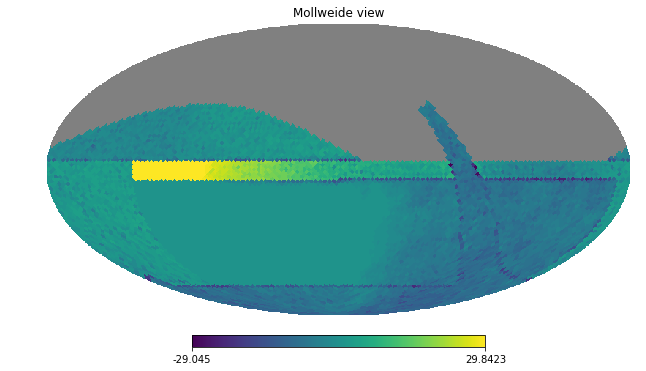

In [9]:
hp.mollview(scheduler.survey_lists[1][2].basis_functions[3](conditions))

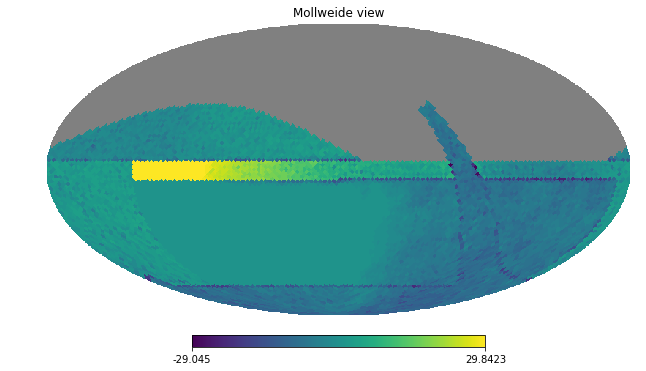

In [28]:
hp.mollview(scheduler.survey_lists[2][0].basis_functions[1](conditions))

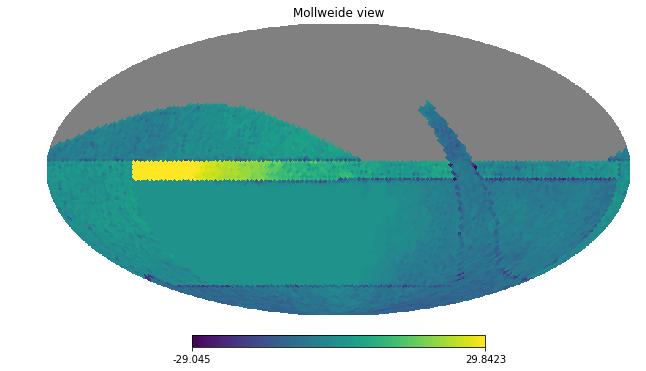

In [53]:
hp.mollview(scheduler.survey_lists[2][1].basis_functions[1](conditions))

In [55]:
scheduler.survey_lists[2][1].basis_functions[1].day_offset

array([-585.64958542, -676.96208542, -403.02458542, ..., -676.96208542,
       -403.02458542, -494.33708542])

In [58]:
seasons = utils.season_calc(conditions.night, offset=scheduler.survey_lists[2][1].basis_functions[1].day_offset,
                                    modulo=scheduler.survey_lists[2][1].basis_functions[1].season_modulo,
                            max_season=scheduler.survey_lists[2][1].basis_functions[1].max_season,
                                    season_length=scheduler.survey_lists[2][1].basis_functions[1].season_length)

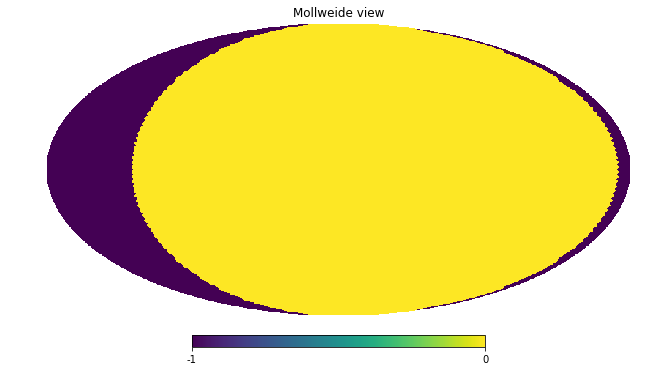

In [59]:
hp.mollview(seasons)

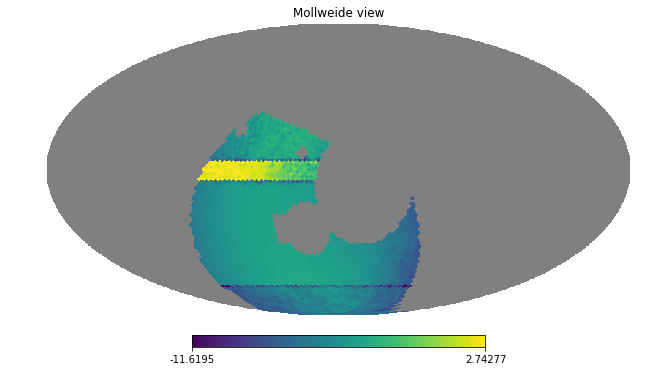

In [60]:
scheduler.survey_lists[2][1].basis_weights = [3.0, 0.3, 3.0, 3.0, 0, 0, 0, 0]
hp.mollview(scheduler.survey_lists[2][1].calc_reward_function(conditions))

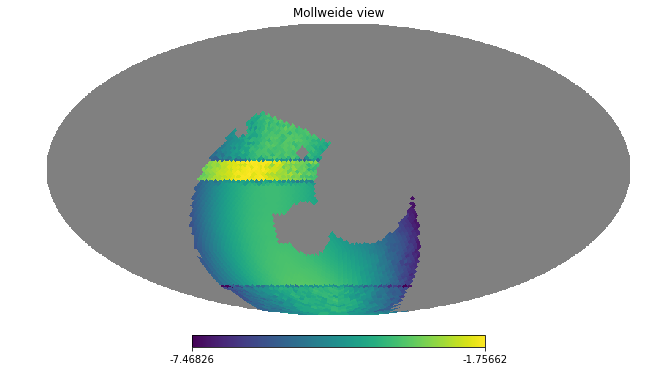

In [65]:
scheduler.survey_lists[2][1].basis_weights = [3.0, 0.1, 3.0, 3.0, 0, 0, 0, 0]

hp.mollview(scheduler.survey_lists[2][1].calc_reward_function(conditions))

In [36]:
scheduler.survey_lists[2][1].basis_functions

In [16]:
scheduler.survey_lists[1][3].basis_functions[3].survey_features

{'N_obs_-1': <lsst.sims.featureScheduler.features.features.N_observations at 0x132845c940>,
 'N_obs_all_-1': <lsst.sims.featureScheduler.features.features.N_observations at 0x132845c978>,
 'N_obs_0': <lsst.sims.featureScheduler.features.features.N_observations_season at 0x132845c438>,
 'N_obs_all_0': <lsst.sims.featureScheduler.features.features.N_observations_season at 0x132845c4a8>,
 'N_obs_1': <lsst.sims.featureScheduler.features.features.N_observations_season at 0x132845c518>,
 'N_obs_all_1': <lsst.sims.featureScheduler.features.features.N_observations_season at 0x132845c588>,
 'N_obs_2': <lsst.sims.featureScheduler.features.features.N_observations_season at 0x132845c9e8>,
 'N_obs_all_2': <lsst.sims.featureScheduler.features.features.N_observations_season at 0x132845ca58>,
 'N_obs_3': <lsst.sims.featureScheduler.features.features.N_observations_season at 0x132845c5f8>,
 'N_obs_all_3': <lsst.sims.featureScheduler.features.features.N_observations_season at 0x132845c6a0>,
 'N_obs_4': 

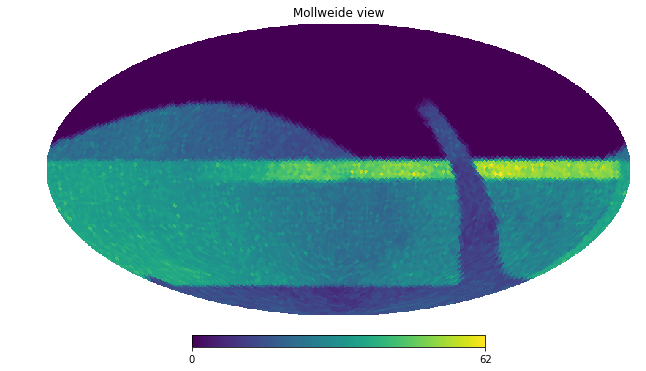

In [17]:
hp.mollview(scheduler.survey_lists[1][3].basis_functions[3].survey_features['N_obs_-1'].feature)

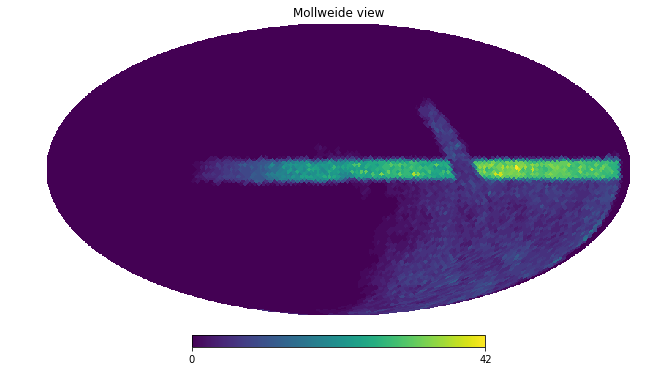

In [19]:
hp.mollview(scheduler.survey_lists[1][3].basis_functions[3].survey_features['N_obs_0'].feature)

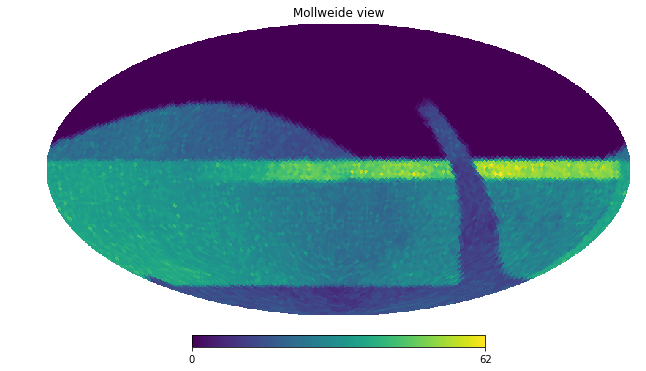

In [24]:
hp.mollview(scheduler.survey_lists[1][3].basis_functions[3].survey_features['N_obs_-1'].feature)

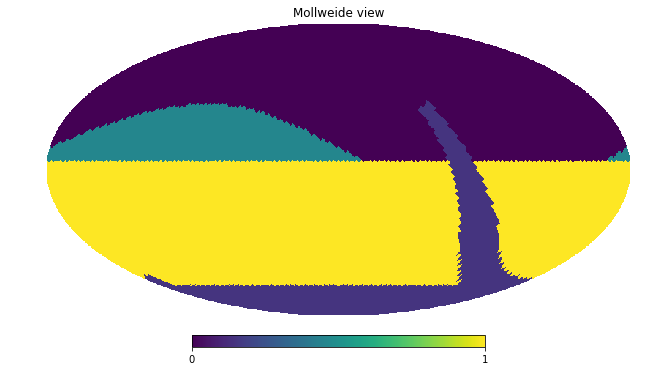

In [36]:
hp.mollview(scheduler.survey_lists[1][3].basis_functions[3].footprints[-1])